# Computação Bioinspirada 2024-02

Este repositório contém o trabalho da Tópicos Avançados em Ciências de Computação II
(Computação Bioinspirada, no semestre 2024-02).

O trabalho consiste em trabalhar com um conjunto de dados multirrótulo onde cada instância representa uma sequência de
proteína. Cada rótulo (classe) corresponde a uma localização subcelular e as proteínas podem estar presentes
simultaneamente em dois ou mais compartimentos celulares. O conjunto de dados possui seis localizações
subcelulares: Proteínas do Capsídeo Viral, Proteínas da Membrana Celular do Hospedeiro, Proteínas do Retículo
Endoplasmático do Hospedeiro, Proteínas do Citoplasma do Hospedeiro, Proteínas do Núcleo do Hospedeiro e
Proteínas Secretadas. As colunas representam os códigos de Gene Ontology (relacionados à função da proteína),
com valores que indicam a frequência do código para cada proteína. As seis últimas colunas indicam a presença
(1) ou ausência (0) da proteína em cada uma das localizações subcelulares mencionadas.

Utilizamos um algoritmo de **PSO** modificado que otimiza a quantidade
de camadas escondidas e neurônios por camada escondida em **redes neurais artificiais**. Além disso, analisamos
e comparamos 3 topologias distintas para o **PSO**.

# Integrantes
- Arthur Queiroz Moura (13671532)
- Julia Carvalho Ribeiro (14691255)
- Téo Sobrino Alves (12557192)


### Imports 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt

2024-12-05 19:18:46.187413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 19:18:50.075969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 19:18:50.081887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 19:18:56.622649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
random_seed = 420
tf.random.set_seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

### Lendo os dados dos datasets e separando em treino e teste

In [3]:
plants_dataset = pd.read_csv('./Plants_Dataset_Term_Frequency.tsv', sep='\t', skiprows=1).iloc[:, 1:]
virus_dataset =  pd.read_csv('./Virus_Dataset_Term_Frequency.tsv', sep='\t', skiprows=1).iloc[:, 1:]

In [4]:
# Os dois datasets possuem 6 rótulos
NUM_ROTULOS_PLANTAS = 12
NUM_ROTULOS_VIRUS = 6
TAMANHO_TEST = 0.3


# Separar as features e os rótulos para o dataset de plantas
X_plants = plants_dataset.iloc[:, :-NUM_ROTULOS_PLANTAS].values  # Todas as colunas, exceto as últimas 6 e a primeira
y_plants = plants_dataset.iloc[:, -NUM_ROTULOS_PLANTAS:].values  # As últimas 6 colunas (rótulos)

# Separar as features e os rótulos para o dataset de vírus
X_virus = virus_dataset.iloc[:, :-NUM_ROTULOS_VIRUS].values
y_virus = virus_dataset.iloc[:, -NUM_ROTULOS_VIRUS:].values

# Dividir dados em treino e teste para o dataset de plantas
X_train_plants, X_test_plants, y_train_plants, y_test_plants = train_test_split(
    X_plants, y_plants, test_size=TAMANHO_TEST, random_state=random_seed
)

# Dividir dados em treino e teste para o dataset de vírus
X_train_virus, X_test_virus, y_train_virus, y_test_virus = train_test_split(
    X_virus, y_virus, test_size=TAMANHO_TEST, random_state=random_seed
)


In [5]:

# Padronizar os dados
scaler_plants = StandardScaler()
X_train_plants = scaler_plants.fit_transform(X_train_plants)
X_test_plants = scaler_plants.transform(X_test_plants)

scaler_virus = StandardScaler()
X_train_virus = scaler_virus.fit_transform(X_train_virus)
X_test_virus = scaler_virus.transform(X_test_virus)

In [6]:
print(f'No dataset das plantas, tenho {len(X_train_plants)} dados de treinamento, {len(X_test_plants)} de teste')
print(f'No dataset dos vírus, tenho {len(X_train_virus)} dados de treinamento, {len(X_test_virus)} de teste')

No dataset das plantas, tenho 675 dados de treinamento, 290 de teste
No dataset dos vírus, tenho 143 dados de treinamento, 62 de teste


In [7]:
def hamming_loss(predictions, actual_values):
    N = len(predictions)
    NUM_ROTULOS = len(predictions[0])

    s = 0

    for i in range(N):
        for j in range(NUM_ROTULOS):
            s += predictions[i][j] ^ actual_values[i][j]
    
    return s / (N * NUM_ROTULOS)

In [8]:
class NeuralNetwork():
    def __init__(self, in_sz, out_sz, h_layer_num, features):
        self.in_sz = in_sz
        self.out_sz = out_sz
        self.h_layer_num = h_layer_num
        self.layer_features = features
        self.model = None
        self.hamming_loss = 0

    def create_model(self):
        model = None
        model = Sequential()
        model.add(Input(shape=(self.in_sz,)))
        self.h_layer_num = 0
        for neur_num, act_func in zip(self.layer_features[0], self.layer_features[1]):
            model.add(Dense(neur_num, activation=act_func))
            self.h_layer_num += 1
        model.add(Dense(self.out_sz, activation='sigmoid'))  # Saída com sigmoid para classificação binária
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model
    
    def train_model(self, X_train, y_train, epochs, batch, val_split):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch, 
                       validation_split=val_split, verbose=0)
    
    def model_loss(self, X_test, y_test):
        predictions_test = self.model.predict(X_test)
        predicted_test = (predictions_test > 0.5).astype(int)
        self.hamming_loss = hamming_loss(predicted_test, y_test)
        
        

In [9]:
# Criar e treinar o modelo ingenuo para plantas
features = [[128, 64], ['leaky_relu', 'leaky_relu']]
nn = NeuralNetwork(X_train_plants.shape[1], y_train_plants.shape[1], 2, features)
nn.create_model()
history_plants = nn.train_model(X_train_plants, y_train_plants, epochs=50, batch=32, val_split=0.3)

2024-12-05 19:19:06.472119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 19:19:09.198717: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Criar e treinar o modelo ingenuo para vírus
nn2 = NeuralNetwork(X_train_virus.shape[1], y_train_virus.shape[1], 2, features)
nn2.create_model()
history_virus = nn2.train_model(X_train_virus, y_train_virus, epochs=50, batch=32, val_split=0.3)

In [11]:
# Obter previsões para o conjunto de teste de plantas
predictions_plants_test = nn.model.predict(X_test_plants)

# Obter previsões para o conjunto de treino de plantas
predictions_plants_train = nn.model.predict(X_train_plants)

# Obter previsões para o conjunto de teste de vírus
predictions_virus_test = nn2.model.predict(X_test_virus)

# Obter previsões para o conjunto de treino de vírus
predictions_virus_train = nn2.model.predict(X_train_virus)


# Transformar as probabilidades em rótulos binários (0 ou 1) com um limiar de 0.5
predicted_classes_plants_test = (predictions_plants_test > 0.5).astype(int)
predicted_classes_plants_train = (predictions_plants_train > 0.5).astype(int)
predicted_classes_virus_test = (predictions_virus_test > 0.5).astype(int)
predicted_classes_virus_train = (predictions_virus_train > 0.5).astype(int)


5/5 [==============================] - 0s 2ms/step


In [12]:
possibilidades = [
    [predicted_classes_plants_train, y_train_plants, 'dados de treino das plantas'],
    [predicted_classes_plants_test, y_test_plants, 'dados de teste das plantas'],
    [predicted_classes_virus_train, y_train_virus, 'dados de treino dos vírus'],
    [predicted_classes_virus_test, y_test_virus, 'dados de teste dos vírus']
]

In [13]:
dados = []
for possibilidade in possibilidades:
    val = hamming_loss(*possibilidade[:-1])
    print(f'A hamming loss nos {possibilidade[-1]} foi de {100*val:.2f}%')
    dados.append(val)

A hamming loss nos dados de treino das plantas foi de 7.12%
A hamming loss nos dados de teste das plantas foi de 6.81%
A hamming loss nos dados de treino dos vírus foi de 5.01%
A hamming loss nos dados de teste dos vírus foi de 12.10%


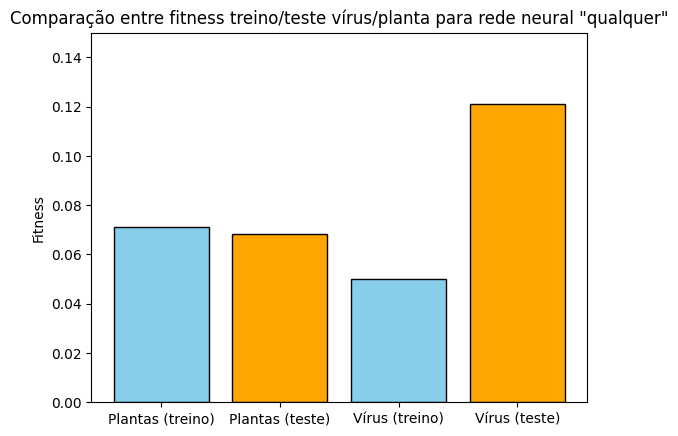

In [14]:
# Criando um gráfico de barras para comparar os valores
plt.bar(['Plantas (treino)', 'Plantas (teste)', 'Vírus (treino)', 'Vírus (teste)'], dados, color=['skyblue', 'orange'] * 2, edgecolor='black')

# Personalizando o gráfico
plt.ylabel('Fitness')
plt.title('Comparação entre fitness treino/teste vírus/planta para rede neural "qualquer"')
plt.ylim(0, 0.15)  # Ajustando o eixo y para destacar a diferença

# Exibindo o gráfico
plt.show()

In [15]:
# possíveis valores para nossa população inicial
LIM_NUM_NEURONS = 300
LIM_INF_NUM_NEURONS = 16
LIM_NUM_LAYERS = 5
LIST_ACT_FUNCS = ['leaky_relu'] #['relu', 'gelu', 'leaky_relu', 'silu']

p_neur = [i for i in range(LIM_INF_NUM_NEURONS, LIM_NUM_NEURONS+1)]
p_h_layers = [i for i in range(1, LIM_NUM_LAYERS+1)]
p_act_func = LIST_ACT_FUNCS


In [16]:
# gerando uma RN com parâmetros 'aleatórios' (dentro de opções pré definidas)

def gen_random_nn(virus=False):
    layers = random.choice(p_h_layers)
    act_funcs = [random.choice(p_act_func) for _ in range(layers)]
    neur_num = [random.choice(p_neur) for _ in range(layers)]
    if not virus:
        nn = NeuralNetwork(X_train_plants.shape[1], y_train_plants.shape[1], layers, [neur_num, act_funcs])
    else:
        nn = NeuralNetwork(X_train_virus.shape[1], y_train_virus.shape[1], layers, [neur_num, act_funcs])    
    return nn
        

In [17]:
# Inicialização da população
class Particle:
    def __init__(self, nn: NeuralNetwork):
        self.nn = nn
        self.position = {
            "neurons": nn.layer_features[0],
            # "activation": nn.layer_features[1],
            'layers': nn.h_layer_num
        }
        self.velocity = {
            "neurons": [random.uniform(-5, 5) for _ in range(nn.h_layer_num)],
            # "activation": [random.uniform(-1, 1) for _ in range(nn.h_layer_num)],
            'layers': random.uniform(-1, 1)
        }
        self.best_position = deepcopy(self.position)
        self.best_loss = float("inf")
        self.current_loss = float("inf")

# Função para atualizar a posição e velocidade de cada partícula
def update_particle(particle, global_best_position, w=0.5, c1=1.5, c2=1.5):

    r1, r2 = random.random(), random.random()
    particle.velocity['layers'] = (
            w * particle.velocity["layers"]
            + c1 * r1 * (particle.best_position["layers"] - particle.position["layers"])
            + c2 * r2 * (global_best_position["layers"] - particle.position["layers"])
        )
    particle.position['layers'] = max(
        1, min(LIM_NUM_LAYERS, round(particle.position["layers"] + particle.velocity["layers"]))
    )

    for i in range(particle.nn.h_layer_num):
        # Atualizar velocidade
        r1, r2 = random.random(), random.random()
        particle.velocity["neurons"][i] = (
            w * particle.velocity["neurons"][i]
            + c1 * r1 * ((0 if i >= len(particle.best_position['neurons']) else particle.best_position["neurons"][i]) - particle.position["neurons"][i])
            + c2 * r2 * ((0 if i >= len(global_best_position['neurons']) else global_best_position["neurons"][i]) - particle.position["neurons"][i])
        )
        # Atualizar posição (respeitando os limites)
        particle.position["neurons"][i] = max(
            LIM_INF_NUM_NEURONS, min(LIM_NUM_NEURONS, round(particle.position["neurons"][i] + particle.velocity["neurons"][i]))
        )

    # Ajustar funções de ativação com base na vizinhança
    # for i in range(len(particle.position["activation"])):
        # particle.velocity["activation"][i] += (w * random.uniform(-1, 1) + c1 * r1 - c2 * r2)
    #    particle.position["activation"][i] = random.choice(p_act_func)
    
    dif = particle.position['layers'] - particle.nn.h_layer_num

    if dif > 0:
        for i in range(dif):
            particle.position['neurons'].append(LIM_INF_NUM_NEURONS)
            particle.velocity['neurons'].append(random.uniform(-5, 5))
    elif dif < 0:
        for i in range(-dif):
            particle.position['neurons'].pop()
            particle.velocity['neurons'].pop()
            
        

# Avaliação do fitness (Hamming Loss)
def evaluate_fitness(particle, X_train, y_train, X_test, y_test):
    print(f'My particle will have position={particle.position}')
    print(f'Its nn layer features before were {particle.nn.layer_features}')
    particle.nn.layer_features = [
        particle.position["neurons"],
        LIST_ACT_FUNCS * particle.position['layers']
    ]
    particle.nn.create_model()
    particle.nn.train_model(X_train, y_train, epochs=50, batch=32, val_split=0.3)
    particle.nn.model_loss(X_test, y_test)
    particle.current_loss = particle.nn.hamming_loss

    # Atualizar melhor posição
    if particle.current_loss < particle.best_loss:
        particle.best_loss = particle.current_loss
        particle.best_position = particle.position

In [18]:

# Função principal para o PSO
def pso_algorithm(X_train, y_train, X_test, y_test, topology_graph, population_size=12, generations=10, virus=False):
    # Gerar população inicial
    population = [Particle(gen_random_nn(virus=virus)) for _ in range(population_size)]
    global_best_loss = float("inf")
    global_best_position = None

    generation_bests = []
    every_particle_stats = []

    for generation in range(generations):
        print(f"Geração {generation + 1}/{generations}")
        fitnesses_and_pos = []
        best_of_gen = float('inf')
        best_of_gen_pos = None

        for particle in population:
            evaluate_fitness(particle, X_train, y_train, X_test, y_test)
            fitnesses_and_pos.append((particle.current_loss, deepcopy(particle.position)))

            # Atualizar melhor global
            if particle.current_loss < global_best_loss:
                global_best_loss = particle.current_loss
                global_best_position = deepcopy(particle.position)
            
            if particle.current_loss < best_of_gen:
                best_of_gen = particle.current_loss
                best_of_gen_pos = deepcopy(particle.position)
        
        every_particle_stats.append(fitnesses_and_pos)
        print(fitnesses_and_pos)
        # Atualizar partículas
        for i, particle in enumerate(population):
            neigs = topology_graph[i]
            melhor_fit, melhor_fit_pos = fitnesses_and_pos[i]
            print(i, neigs, melhor_fit, melhor_fit_pos)
            for neig in neigs:
                if fitnesses_and_pos[neig][0] < melhor_fit:
                    melhor_fit, melhor_fit_pos = fitnesses_and_pos[neig]
            update_particle(particle, melhor_fit_pos)

        #for particle in population:
        #    update_particle(particle, global_best_position)

        print(f"Melhor Hamming Loss da geração {generation}: {global_best_loss:.4f}")
        generation_bests.append((best_of_gen, best_of_gen_pos))

    print(f'O melhor cara foi {global_best_position} e teve hamming loss {global_best_loss}')

    return generation_bests, every_particle_stats, global_best_loss, global_best_position

In [19]:
pop_size = 12
ring_graph = [[(i-1) % pop_size, (i+1) % pop_size] for i in range(pop_size)]

In [20]:
gen_bests_ring, every_part_bests_ring, global_best_ring, global_best_pos_ring = pso_algorithm(X_train_plants, y_train_plants, X_test_plants, y_test_plants, ring_graph, population_size=pop_size, generations=20)

Geração 1/20
My particle will have position={'neurons': [155], 'layers': 1}
Its nn layer features before were [[155], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [283], 'layers': 1}
Its nn layer features before were [[283], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [295], 'layers': 1}
Its nn layer features before were [[295], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [155], 'layers': 1}
Its nn layer features before were [[155], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [68, 142, 269], 'layers': 3}
Its nn layer features before were [[68, 142, 269], ['leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 1ms/step
My particle will have position={'neurons': [87, 286, 20, 155, 77], 'lay

In [21]:
every_graph = [[] for _ in range(pop_size)]

for i in range(pop_size):
    for j in range(len(every_part_bests_ring)):
        every_graph[i].append(every_part_bests_ring[j][i][0])

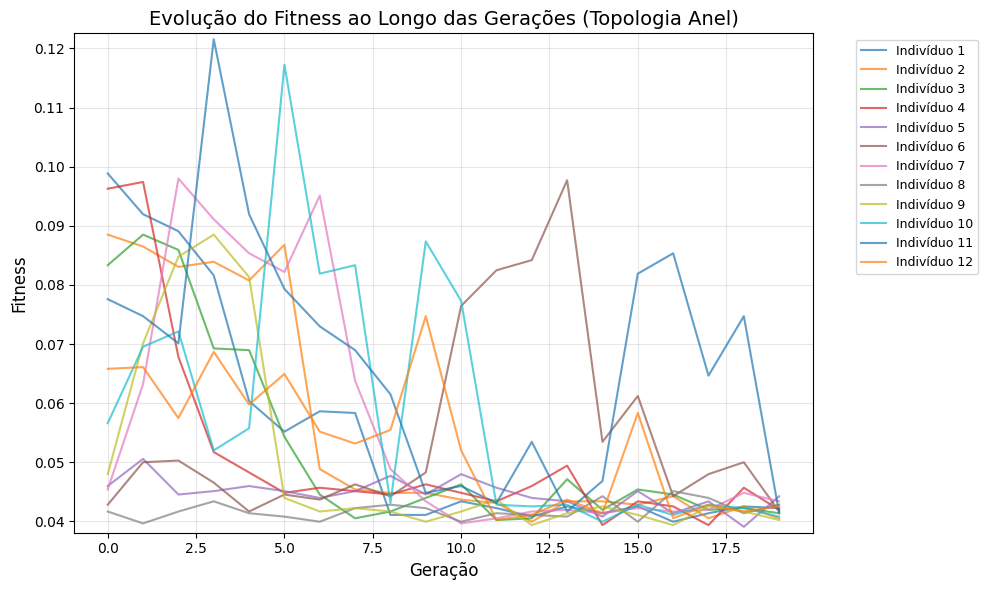

In [22]:
num_generations = len(every_part_bests_ring)
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

for i in range(pop_size):
    plt.plot(range(num_generations), every_graph[i], label=f"Indivíduo {i + 1}", alpha=0.7)

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Evolução do Fitness ao Longo das Gerações (Topologia Anel)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y para destacar os valores próximos
plt.ylim([min(min(row) for row in every_graph) - 0.001, max(max(row) for row in every_graph) + 0.001])

# Legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

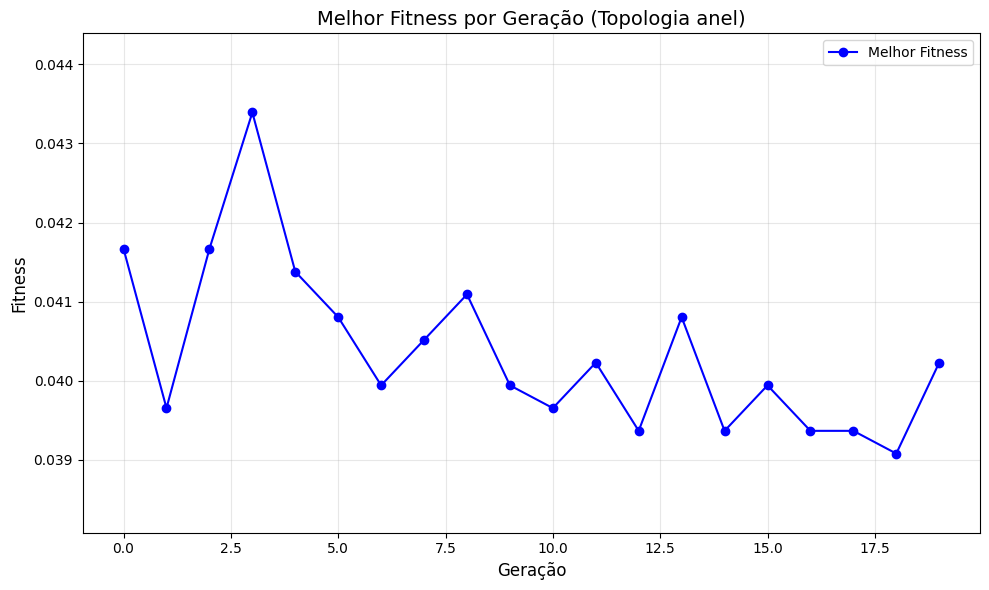

In [23]:
# Supondo que você já tenha a lista gen_bests
# Extrair o fitness (primeiro elemento) de cada tupla
best_fitness_per_generation = [generation[0] for generation in gen_bests_ring]

# Número de gerações
num_generations = len(best_fitness_per_generation)

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

# Plotar o melhor fitness por geração
plt.plot(range(num_generations), best_fitness_per_generation, marker='o', color='b', label="Melhor Fitness")

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Melhor Fitness por Geração (Topologia anel)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y (valores muito próximos)
plt.ylim([min(best_fitness_per_generation) - 0.001, max(best_fitness_per_generation) + 0.001])

# Legenda
plt.legend(fontsize=10)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [24]:
global_topology = [[j for j in range(pop_size) if j != i] for i in range(pop_size)]

In [25]:
gen_bests_globaltopo, every_part_bests_globaltopo, global_best_globaltopo, global_best_pos_globaltopo = pso_algorithm(X_train_plants, y_train_plants, X_test_plants, y_test_plants, global_topology, population_size=pop_size, generations=20)

Geração 1/20
My particle will have position={'neurons': [222, 123], 'layers': 2}
Its nn layer features before were [[222, 123], ['leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 1ms/step
My particle will have position={'neurons': [126, 101, 242, 229, 223], 'layers': 5}
Its nn layer features before were [[126, 101, 242, 229, 223], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [140], 'layers': 1}
Its nn layer features before were [[140], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [185, 33, 95, 50], 'layers': 4}
Its nn layer features before were [[185, 33, 95, 50], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [266, 90, 107], 'layers': 3}
Its nn layer features before were

In [26]:
every_graph_global = [[] for _ in range(pop_size)]

for i in range(pop_size):
    for j in range(len(every_part_bests_globaltopo)):
        every_graph_global[i].append(every_part_bests_globaltopo[j][i][0])

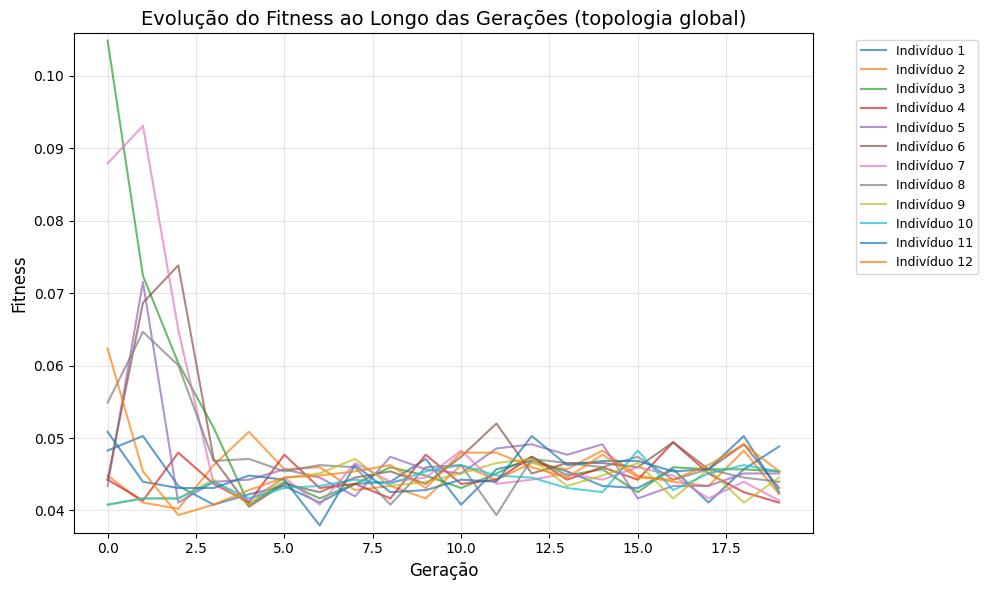

In [27]:
num_generations = len(every_part_bests_globaltopo)
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

for i in range(pop_size):
    plt.plot(range(num_generations), every_graph_global[i], label=f"Indivíduo {i + 1}", alpha=0.7)

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Evolução do Fitness ao Longo das Gerações (topologia global)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y para destacar os valores próximos
plt.ylim([min(min(row) for row in every_graph_global) - 0.001, max(max(row) for row in every_graph_global) + 0.001])

# Legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

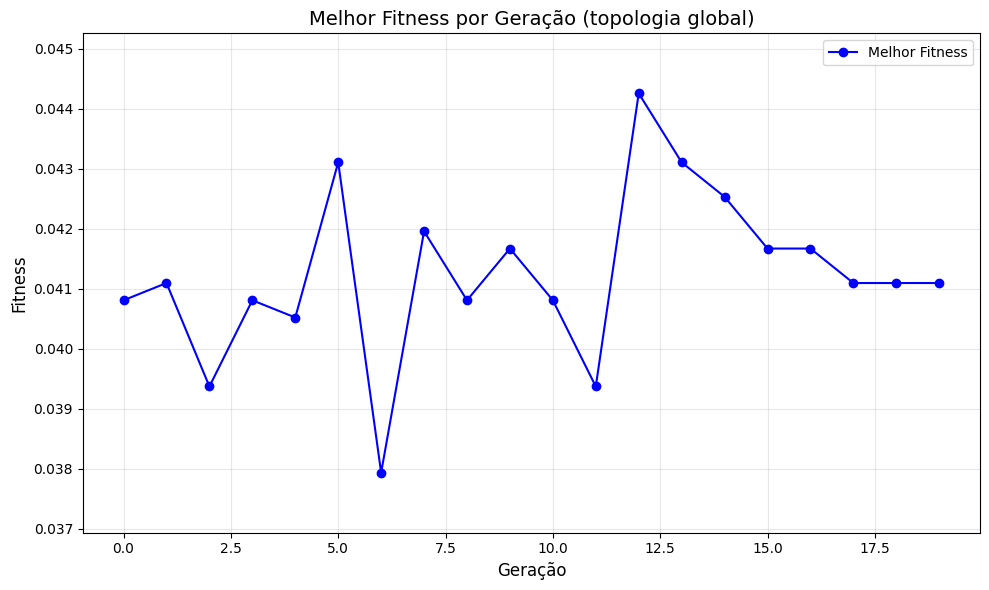

In [28]:
# Supondo que você já tenha a lista gen_bests
# Extrair o fitness (primeiro elemento) de cada tupla
best_fitness_per_generation = [generation[0] for generation in gen_bests_globaltopo]

# Número de gerações
num_generations = len(best_fitness_per_generation)

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

# Plotar o melhor fitness por geração
plt.plot(range(num_generations), best_fitness_per_generation, marker='o', color='b', label="Melhor Fitness")

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Melhor Fitness por Geração (topologia global)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y (valores muito próximos)
plt.ylim([min(best_fitness_per_generation) - 0.001, max(best_fitness_per_generation) + 0.001])

# Legenda
plt.legend(fontsize=10)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [29]:
"""  
Van neumann

0 1 2 3
4 5 6 7
8 9 10 11

linha i, coluna j --> id 4i+j

"""

def pega_id_viz(i, j):
    vizs = []
    for ii in range(3):
        for jj in range(4):
            if abs(i-ii) + abs(j-jj) == 1:
                vizs.append(4*ii+jj)
    return vizs

van_neumann_graph = [pega_id_viz(i, j) for i in range(3) for j in range(4)]

In [30]:
gen_bests_van_neumanntopo, every_part_bests_van_neumanntopo, global_best_van_neumanntopo, global_best_pos_van_neumanntopo = pso_algorithm(X_train_plants, y_train_plants, X_test_plants, y_test_plants, van_neumann_graph, population_size=pop_size, generations=20)

Geração 1/20
My particle will have position={'neurons': [250, 136], 'layers': 2}
Its nn layer features before were [[250, 136], ['leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [294], 'layers': 1}
Its nn layer features before were [[294], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [129, 230, 64, 76, 230], 'layers': 5}
Its nn layer features before were [[129, 230, 64, 76, 230], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [231, 106, 72, 61, 231], 'layers': 5}
Its nn layer features before were [[231, 106, 72, 61, 231], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [146, 31, 110, 117], 'layers': 4}
Its nn

In [31]:
every_graph_neumann = [[] for _ in range(pop_size)]

for i in range(pop_size):
    for j in range(len(every_part_bests_van_neumanntopo)):
        every_graph_neumann[i].append(every_part_bests_van_neumanntopo[j][i][0])

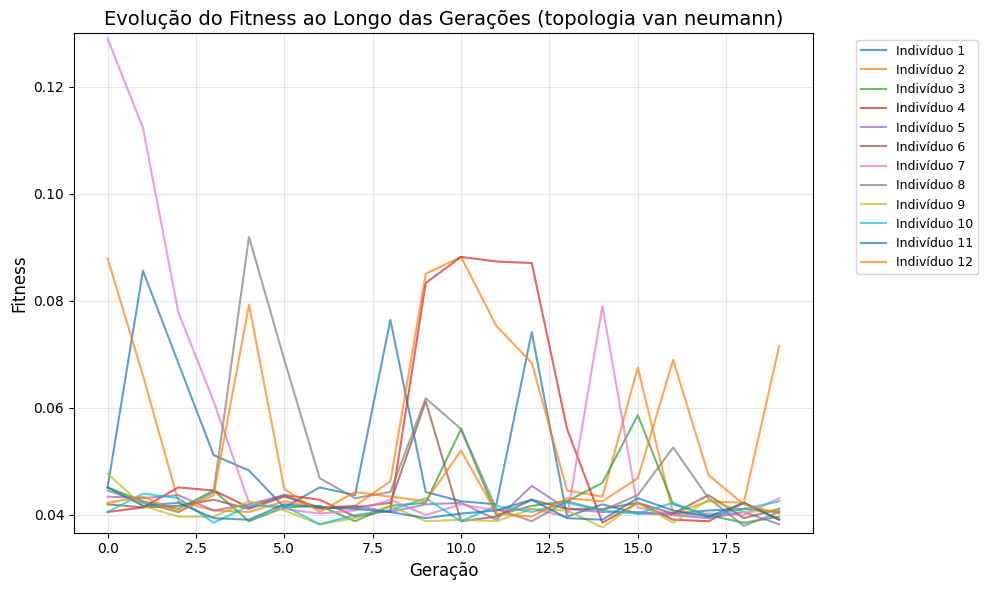

In [32]:
num_generations = len(every_part_bests_van_neumanntopo)
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

for i in range(pop_size):
    plt.plot(range(num_generations), every_graph_neumann[i], label=f"Indivíduo {i + 1}", alpha=0.7)

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Evolução do Fitness ao Longo das Gerações (topologia van neumann)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y para destacar os valores próximos
plt.ylim([min(min(row) for row in every_graph_neumann) - 0.001, max(max(row) for row in every_graph_neumann) + 0.001])

# Legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

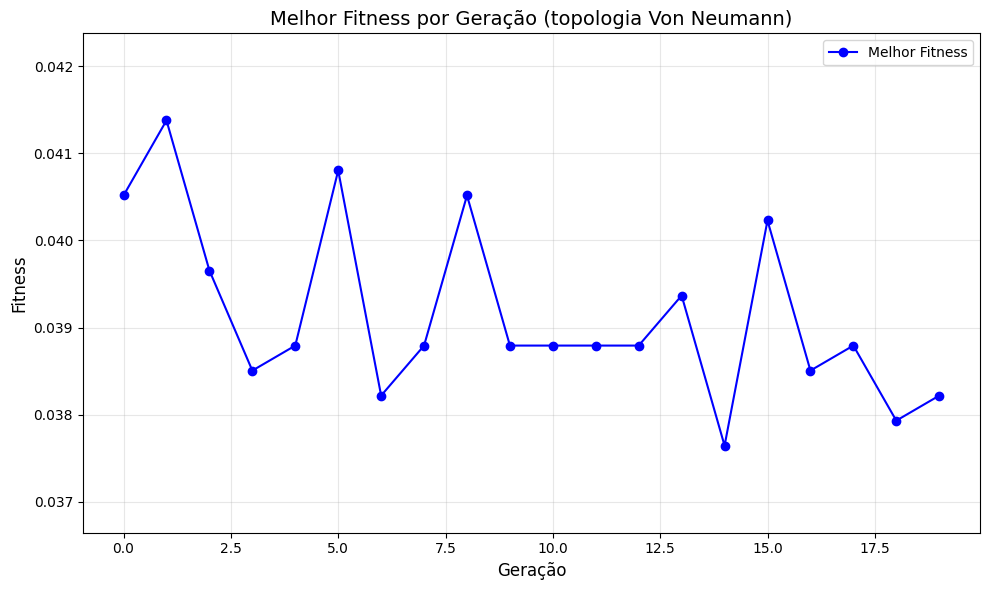

In [33]:
# Supondo que você já tenha a lista gen_bests
# Extrair o fitness (primeiro elemento) de cada tupla
best_fitness_per_generation = [generation[0] for generation in gen_bests_van_neumanntopo]

# Número de gerações
num_generations = len(best_fitness_per_generation)

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

# Plotar o melhor fitness por geração
plt.plot(range(num_generations), best_fitness_per_generation, marker='o', color='b', label="Melhor Fitness")

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Melhor Fitness por Geração (topologia Von Neumann)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y (valores muito próximos)
plt.ylim([min(best_fitness_per_generation) - 0.001, max(best_fitness_per_generation) + 0.001])

# Legenda
plt.legend(fontsize=10)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

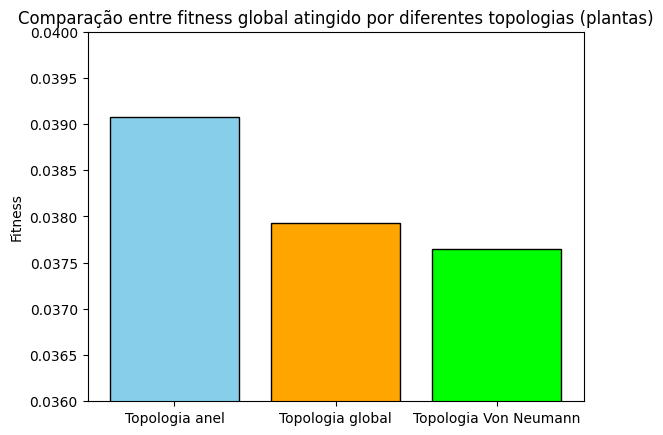

0.03908045977011494 0.03793103448275862 0.03764367816091954
{'neurons': [246, 25, 300, 148, 42], 'layers': 5}
{'neurons': [300, 287, 300], 'layers': 3}


In [34]:
# Criando um gráfico de barras para comparar os valores
plt.bar(['Topologia anel', 'Topologia global', 'Topologia Von Neumann'], [global_best_ring, global_best_globaltopo, global_best_van_neumanntopo], color=['skyblue', 'orange', 'lime'], edgecolor='black')

# Personalizando o gráfico
plt.ylabel('Fitness')
plt.title('Comparação entre fitness global atingido por diferentes topologias (plantas)')
plt.ylim(0.036, 0.040)  # Ajustando o eixo y para destacar a diferença

# Exibindo o gráfico
plt.show()

print(global_best_ring, global_best_globaltopo, global_best_van_neumanntopo)
print(global_best_pos_globaltopo)
print(global_best_pos_van_neumanntopo)

In [35]:
virus_gen_bests_globaltopo, virus_every_part_bests_globaltopo, virus_global_best_globaltopo, virus_global_best_pos_globaltopo = pso_algorithm(X_train_virus, y_train_virus, X_test_virus, y_test_virus, global_topology, population_size=pop_size, generations=20, virus=True)

Geração 1/20
My particle will have position={'neurons': [97, 44, 116, 181, 232], 'layers': 5}
Its nn layer features before were [[97, 44, 116, 181, 232], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [243, 184, 163], 'layers': 3}
Its nn layer features before were [[243, 184, 163], ['leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 3ms/step
My particle will have position={'neurons': [147, 289, 139, 274], 'layers': 4}
Its nn layer features before were [[147, 289, 139, 274], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [67], 'layers': 1}
Its nn layer features before were [[67], ['leaky_relu']]
2/2 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [146, 133, 278, 185, 271], 'layers': 5}
Its nn

In [36]:
virus_gen_bests_ringtopo, virus_every_part_bests_ringtopo, virus_global_best_ringtopo, virus_global_best_pos_ringtopo = pso_algorithm(X_train_virus, y_train_virus, X_test_virus, y_test_virus, ring_graph, population_size=pop_size, generations=20, virus=True)

Geração 1/20
My particle will have position={'neurons': [26, 277, 116, 209, 244], 'layers': 5}
Its nn layer features before were [[26, 277, 116, 209, 244], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 3ms/step
My particle will have position={'neurons': [246, 228, 261, 41], 'layers': 4}
Its nn layer features before were [[246, 228, 261, 41], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 3ms/step
My particle will have position={'neurons': [163, 37, 263, 243], 'layers': 4}
Its nn layer features before were [[163, 37, 263, 243], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 3ms/step
My particle will have position={'neurons': [127, 242, 154, 76, 32], 'layers': 5}
Its nn layer features before were [[127, 242, 154, 76, 32], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [===================

In [37]:
every_graph = [[] for _ in range(pop_size)]

for i in range(pop_size):
    for j in range(len(virus_every_part_bests_ringtopo)):
        every_graph[i].append(virus_every_part_bests_ringtopo[j][i][0])

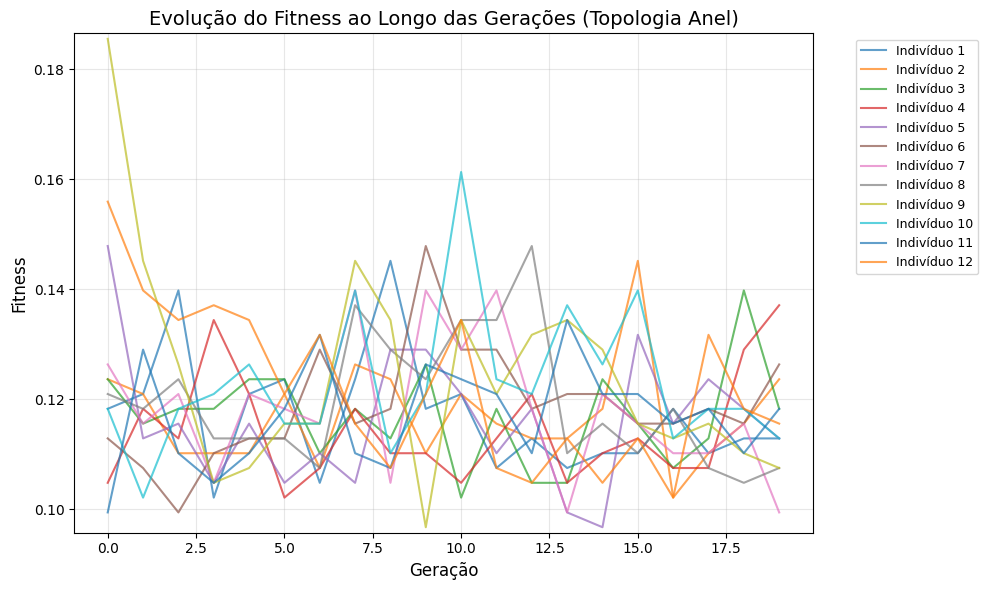

In [38]:
num_generations = len(virus_every_part_bests_ringtopo)
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

for i in range(pop_size):
    plt.plot(range(num_generations), every_graph[i], label=f"Indivíduo {i + 1}", alpha=0.7)

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Evolução do Fitness ao Longo das Gerações (Topologia Anel)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y para destacar os valores próximos
plt.ylim([min(min(row) for row in every_graph) - 0.001, max(max(row) for row in every_graph) + 0.001])

# Legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [39]:
virus_gen_bests_neumanntopo, virus_every_part_bests_neumanntopo, virus_global_best_neumanntopo, virus_global_best_pos_neumanntopo = pso_algorithm(X_train_virus, y_train_virus, X_test_virus, y_test_virus, ring_graph, population_size=pop_size, generations=20, virus=True)

Geração 1/20
My particle will have position={'neurons': [215, 238, 292, 139], 'layers': 4}
Its nn layer features before were [[215, 238, 292, 139], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 3ms/step
My particle will have position={'neurons': [225, 18, 48, 209], 'layers': 4}
Its nn layer features before were [[225, 18, 48, 209], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [16, 74], 'layers': 2}
Its nn layer features before were [[16, 74], ['leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [159, 216, 185, 43, 104], 'layers': 5}
Its nn layer features before were [[159, 216, 185, 43, 104], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
2/2 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [1

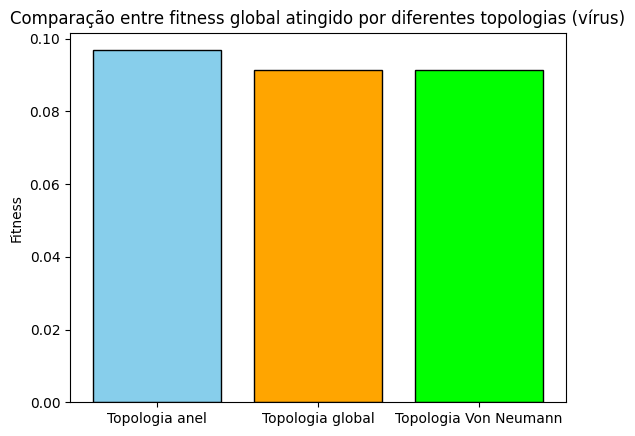

0.03908045977011494 0.03793103448275862 0.03764367816091954
0.0967741935483871
0.0913978494623656
0.0913978494623656


In [61]:
# Criando um gráfico de barras para comparar os valores
plt.bar(['Topologia anel', 'Topologia global', 'Topologia Von Neumann'], [virus_global_best_ringtopo, virus_global_best_globaltopo, virus_global_best_neumanntopo], color=['skyblue', 'orange', 'lime'], edgecolor='black')

# Personalizando o gráfico
plt.ylabel('Fitness')
plt.title('Comparação entre fitness global atingido por diferentes topologias (vírus)')

# Exibindo o gráfico
plt.show()

print(global_best_ring, global_best_globaltopo, global_best_van_neumanntopo)
print(virus_global_best_ringtopo)
print(virus_global_best_globaltopo)
print(virus_global_best_neumanntopo)

In [42]:
def get_class_freqs(nome_dataset, y_train, y_test):
    print(f'O dataset {nome_dataset} possui {len(y_train[0])} classificações')
    print('Nos dados de treino...')
    somas = np.sum(y_train, axis=0)

    for i in range(len(y_train[0])):
        print(f'A taxa de membros da classe {i} eh {somas[i]}/{len(y_train)} = {100*somas[i]/len(y_train):.2f}%')
    print('Nos dados de teste...')
    somas = np.sum(y_test, axis=0)

    for i in range(len(y_test[0])):
        print(f'A taxa de membros da classe {i} eh {somas[i]}/{len(y_test)} = {100*somas[i]/len(y_test):.2f}%')
    

In [43]:
get_class_freqs('plantas', y_train_plants, y_test_plants)

O dataset plantas possui 12 classificações
Nos dados de treino...
A taxa de membros da classe 0 eh 42/675 = 6.22%
A taxa de membros da classe 1 eh 25/675 = 3.70%
A taxa de membros da classe 2 eh 189/675 = 28.00%
A taxa de membros da classe 3 eh 122/675 = 18.07%
A taxa de membros da classe 4 eh 32/675 = 4.74%
A taxa de membros da classe 5 eh 15/675 = 2.22%
A taxa de membros da classe 6 eh 18/675 = 2.67%
A taxa de membros da classe 7 eh 104/675 = 15.41%
A taxa de membros da classe 8 eh 95/675 = 14.07%
A taxa de membros da classe 9 eh 15/675 = 2.22%
A taxa de membros da classe 10 eh 30/675 = 4.44%
A taxa de membros da classe 11 eh 37/675 = 5.48%
Nos dados de teste...
A taxa de membros da classe 0 eh 13/290 = 4.48%
A taxa de membros da classe 1 eh 7/290 = 2.41%
A taxa de membros da classe 2 eh 88/290 = 30.34%
A taxa de membros da classe 3 eh 59/290 = 20.34%
A taxa de membros da classe 4 eh 10/290 = 3.45%
A taxa de membros da classe 5 eh 7/290 = 2.41%
A taxa de membros da classe 6 eh 3/290 

In [44]:
get_class_freqs('virus', y_train_virus, y_test_virus)

O dataset virus possui 6 classificações
Nos dados de treino...
A taxa de membros da classe 0 eh 5/143 = 3.50%
A taxa de membros da classe 1 eh 23/143 = 16.08%
A taxa de membros da classe 2 eh 11/143 = 7.69%
A taxa de membros da classe 3 eh 60/143 = 41.96%
A taxa de membros da classe 4 eh 58/143 = 40.56%
A taxa de membros da classe 5 eh 16/143 = 11.19%
Nos dados de teste...
A taxa de membros da classe 0 eh 2/62 = 3.23%
A taxa de membros da classe 1 eh 9/62 = 14.52%
A taxa de membros da classe 2 eh 9/62 = 14.52%
A taxa de membros da classe 3 eh 27/62 = 43.55%
A taxa de membros da classe 4 eh 26/62 = 41.94%
A taxa de membros da classe 5 eh 4/62 = 6.45%


In [ ]:
def accur_exata():
    pass

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score, hamming_loss as hamming_loss_sk

In [49]:
print(virus_global_best_pos_globaltopo)

{'neurons': [300, 65], 'layers': 2}


In [63]:
modelos = [
    ('virus_global', virus_global_best_pos_globaltopo),
    ('virus_neumann', virus_global_best_pos_neumanntopo),
    ('virus_anel', virus_global_best_pos_ringtopo),
    ('plantas_global', global_best_pos_globaltopo),
    ('plantas_neumann', global_best_pos_van_neumanntopo),
    ('plantas_anel', global_best_pos_ring)
]

for i in range(len(modelos)):
    if modelos[i][0].startswith('virus'):
        el_cara = NeuralNetwork(len(X_test_virus[0]), len(y_test_virus[0]), modelos[i][1]['layers'], modelos[i][1]['neurons'])
        el_cara.layer_features = [
            modelos[i][1]['neurons'],
            LIST_ACT_FUNCS * modelos[i][1]['layers']
        ]
        el_cara.create_model()
        el_cara.train_model(X_train_virus, y_train_virus, epochs=50, batch=32, val_split=0.3)
        y_true = y_test_virus
        xtest = X_test_virus
        y_pred = (el_cara.model.predict(X_test_virus) > 0.5).astype(int)
    else:
        el_cara = NeuralNetwork(len(X_test_plants[0]), len(y_test_plants[0]), modelos[i][1]['layers'], modelos[i][1]['neurons'])
        el_cara.layer_features = [
            modelos[i][1]['neurons'],
            LIST_ACT_FUNCS * modelos[i][1]['layers']
        ]
        el_cara.create_model()
        el_cara.train_model(X_train_plants, y_train_plants, epochs=50, batch=32, val_split=0.3)
        y_true = y_test_plants
        xtest = X_test_plants
        y_pred = (el_cara.model.predict(X_test_plants) > 0.5).astype(int)
    print(f'O modelo {modelos[i][0]} teve: ')
    print(f'Topologia: {modelos[i][1]["layers"]} camadas convolucionais: {modelos[i][1]["neurons"]}')
    print(f'Hamming Loss: {hamming_loss_sk(y_true, y_pred)}')
    print(f'Accuracy Score: {accuracy_score(y_true, y_pred)}')
    print(f'Log Loss: {log_loss(y_true, y_pred)}')
    print('='*50)
    print('\n'*3)

2/2 [==============================] - 0s 4ms/step
O modelo virus_global teve: 
Topologia: 2 camadas convolucionais: [300, 65]
Hamming Loss: 0.09946236559139784
Accuracy Score: 0.6451612903225806
Log Loss: 11.912933609022904




2/2 [==============================] - 0s 2ms/step
O modelo virus_neumann teve: 
Topologia: 4 camadas convolucionais: [300, 63, 33, 16]
Hamming Loss: 0.09946236559139784
Accuracy Score: 0.6290322580645161
Log Loss: 10.37121997853154




2/2 [==============================] - 0s 2ms/step
O modelo virus_anel teve: 
Topologia: 5 camadas convolucionais: [16, 81, 181, 17, 23]
Hamming Loss: 0.12634408602150538
Accuracy Score: 0.4838709677419355
Log Loss: 10.602414748754516




10/10 [==============================] - 0s 2ms/step
O modelo plantas_global teve: 
Topologia: 5 camadas convolucionais: [246, 25, 300, 148, 42]
Hamming Loss: 0.04195402298850575
Accuracy Score: 0.6724137931034483
Log Loss: 7.882565693056627




10/10 [==============================] - 0s 2ms/s